# **Propensity Analysis**

RFM been a famous method to build a customer segmentation. We can easily generate segment based on user Recency, Frequency, and Monetary. This segment information very usefull for customer targeting, customer behavious analysis and understanding our customer tier. But sometimes, we need the exact number about our customer quality or we need to know the our customer score based on a view metrics. So basically Propensity Modelling is method to solve that problem. Propensity Modelling in a nutshell is a method to generate probability score on how customer do a particular action. In this project I will combine the Propensity Analysis using RFM metrics to show the probability score of how customer order activity after they get campaign

The dataset contain user RFM before they get campaign and we will predict using label in 'Retail_Data_Response.csv'

In [1]:
# Extracting the libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import warnings
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/retailtransactiondata/Retail_Data_Response.csv
/kaggle/input/retailtransactiondata/Retail_Data_Transactions.csv


In [2]:
df1 = pd.read_csv('/kaggle/input/retailtransactiondata/Retail_Data_Response.csv')
df2 = pd.read_csv('/kaggle/input/retailtransactiondata/Retail_Data_Transactions.csv',parse_dates=['trans_date'])

In [3]:
df1.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [4]:
df2.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [5]:
df1.describe(include='all')

,customer_id,response
count,6884,6884.000000
unique,6884,NaN
top,CS5067,NaN
freq,1,NaN
mean,NaN,0.093986
std,NaN,0.291831
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,0.000000


In [6]:
df2.describe(include='all')

,customer_id,trans_date,tran_amount
count,125000,125000,125000.000000
unique,6889,1401,NaN
top,CS4424,2011-07-16 00:00:00,NaN
freq,39,141,NaN
first,NaN,2011-05-16 00:00:00,NaN
last,NaN,2015-03-16 00:00:00,NaN
mean,NaN,NaN,64.991912
std,NaN,NaN,22.860006
min,NaN,NaN,10.000000
25%,NaN,NaN,47.000000


In [7]:
print(df2['trans_date'].min())
print(df2['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


Based on information above that the transaction data were taken from 16 May 2011 - 16 March 2015, we will assume that campaign data in df1 were campaign conduct in 17 March 2014. So, the propensity Modelling will see the RFM value of user for last 4 years (we assume all transaction history of user since their first transaction)

In [8]:
sd = dt.datetime(2015,3,17)
df2['recent']= sd - df2['trans_date']
df2['recent'].astype('timedelta64[D]')
df2['recent']=df2['recent'] / np.timedelta64(1, 'D')
df2.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0


In [9]:
data_rfm = df2.groupby('customer_id').agg({'recent': lambda x:x.min(), # Recency
                                        'customer_id': lambda x: len(x),               # Frequency
                                        'tran_amount': lambda x: x.sum()})          # Monetary Value

data_rfm.rename(columns={'recent': 'recency', 
                         'customer_id': 'frequency', 
                         'tran_amount': 'monetary_value'}, inplace=True)

In [10]:
rfm = data_rfm.reset_index()

In [11]:
rfm.head()

,customer_id,recency,frequency,monetary_value
0,CS1112,62.0,15,1012
1,CS1113,36.0,20,1490
2,CS1114,33.0,19,1432
3,CS1115,12.0,22,1659
4,CS1116,204.0,13,857


In [12]:
rfm.describe(include='all')

,customer_id,recency,frequency,monetary_value
count,6889,6889.000000,6889.000000,6889.000000
unique,6889,NaN,NaN,NaN
top,CS5067,NaN,NaN,NaN
freq,1,NaN,NaN,NaN
mean,NaN,81.538249,18.144869,1179.269705
std,NaN,85.382526,5.193014,465.832609
min,NaN,1.000000,4.000000,149.000000
25%,NaN,23.000000,14.000000,781.000000
50%,NaN,54.000000,18.000000,1227.000000
75%,NaN,112.000000,22.000000,1520.000000


In [13]:
label = df1.groupby('response').agg({'customer_id': lambda x: len(x)})
label.head()

,customer_id
response,
0,6237
1,647


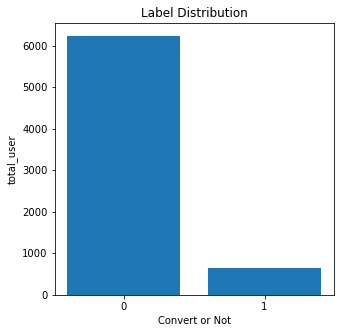

In [14]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,label['customer_id'])
plt.xticks(label.index)
plt.title('Label Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('total_user')
plt.show()

We can see that we have an imbalanced data here. In order to optimize the model, we can perform a view method to handle this imbalanced data. In this project I will try to use undersample and oversample method and see which method perform best.

In [15]:
dataset = pd.merge(df1,rfm)
dataset.head()

,customer_id,response,recency,frequency,monetary_value
0,CS1112,0,62.0,15,1012
1,CS1113,0,36.0,20,1490
2,CS1114,1,33.0,19,1432
3,CS1115,1,12.0,22,1659
4,CS1116,1,204.0,13,857


### Under Sample

In [16]:
# Define the minority data size and indices
minority_class_len = len(dataset[dataset['response'] == 1])
minority_index_list = dataset[dataset['response'] == 1].index
print(minority_index_list)

Int64Index([   2,    3,    4,    6,   23,   29,   30,   31,   33,   36,
            ...
            6428, 6464, 6475, 6528, 6595, 6645, 6728, 6738, 6788, 6854],
           dtype='int64', length=647)


In [17]:
#Define the majority data size and indices
majority_class_len = len(dataset[dataset['response'] == 0])
majority_index_list = dataset[dataset['response'] == 0].index
print(majority_index_list)

Int64Index([   0,    1,    5,    7,    8,    9,   10,   11,   12,   13,
            ...
            6874, 6875, 6876, 6877, 6878, 6879, 6880, 6881, 6882, 6883],
           dtype='int64', length=6237)


In [18]:
#Perform random undersampling
random_majority = np.random.choice(majority_index_list,
                                   minority_class_len,
                                   replace = False)
under_sample_indexlist = np.concatenate([random_majority,minority_index_list])
under_sample = dataset.loc[under_sample_indexlist]
under_sample.reset_index(drop=True, inplace=True)
under_sample.head()

,customer_id,response,recency,frequency,monetary_value
0,CS5205,0,54.0,17,1185
1,CS7885,0,3.0,14,630
2,CS8901,0,191.0,13,600
3,CS3558,0,13.0,20,1449
4,CS7667,0,74.0,15,636


In [19]:
label_us = under_sample.groupby('response').agg({'customer_id': lambda x: len(x)})
label_us.head()

,customer_id
response,
0,647
1,647


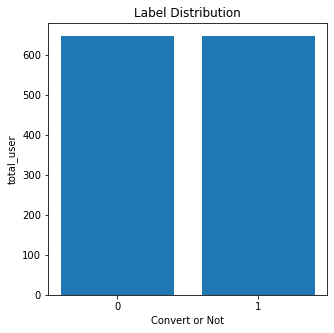

In [20]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,label_us['customer_id'])
plt.xticks(label_us.index)
plt.title('Label Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('total_user')
plt.show()

### Over Sample

In [21]:
from sklearn.utils import resample

In [22]:
# Separate input features and target
y = dataset.response
X = dataset.drop('response', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

In [23]:
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)
X.head()

,customer_id,recency,frequency,monetary_value,response
2634,CS3746,74.0,19,1475,0
4905,CS6017,3.0,28,2109,0
2436,CS3548,38.0,19,1398,0
1875,CS2987,89.0,20,1508,0
5717,CS7832,104.0,20,905,0


In [24]:
# separate minority and majority classes
not_order = X[X.response==0]
order = X[X.response==1]

# upsample minority
order_upsampled = resample(order,
                          replace=True, # sample with replacement
                          n_samples=len(not_order), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_order, order_upsampled])
upsampled.reset_index(drop=True, inplace=True)
upsampled.head()

,customer_id,recency,frequency,monetary_value,response
0,CS3746,74.0,19,1475,0
1,CS6017,3.0,28,2109,0
2,CS3548,38.0,19,1398,0
3,CS2987,89.0,20,1508,0
4,CS7832,104.0,20,905,0


In [25]:
label_os = upsampled.groupby('response').agg({'customer_id': lambda x: len(x)})
label_os.head()

,customer_id
response,
0,4676
1,4676


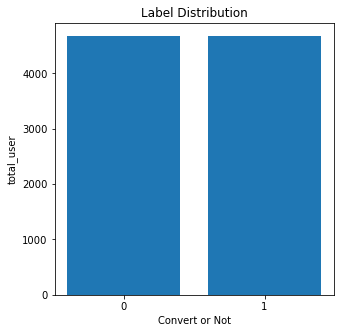

In [26]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,label_os['customer_id'])
plt.xticks(label_os.index)
plt.title('Label Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('total_user')
plt.show()

## XGBoost Modelling

### **UnderSample dataset**

In [27]:
x = under_sample.drop(columns=['response','customer_id'])
y = under_sample['response']
identifier = under_sample['customer_id']

for i in range(0,100):
    skf = StratifiedKFold(n_splits=5, random_state = i, shuffle = True)
        
predicted_y = []
expected_y = []
customer_id = []

for train_index, test_index in skf.split(x, y):
    x_train, x_test = x.loc[train_index], x.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    id_train, id_test = identifier[train_index], identifier[test_index]
    
    xgb_model = xgb.XGBClassifier(objective='binary:logistic').fit(x.loc[train_index], y[train_index])
    predictions = xgb_model.predict(x.loc[test_index])

    predicted_y.extend(predictions)
    expected_y.extend(y_test)
    customer_id.extend(id_test)
    
result = {'id': customer_id,'pred': predicted_y, 'exp': expected_y}    
report = classification_report(expected_y, predicted_y)
print(report)

              precision    recall  f1-score   support

           0       0.63      0.61      0.62       647
           1       0.62      0.65      0.63       647

    accuracy                           0.63      1294
   macro avg       0.63      0.63      0.63      1294
weighted avg       0.63      0.63      0.63      1294



In [28]:
score = pd.DataFrame(data=result)
score.head()

,id,pred,exp
0,CS3558,0,0
1,CS1916,0,0
2,CS3779,0,0
3,CS7153,0,0
4,CS1667,1,0


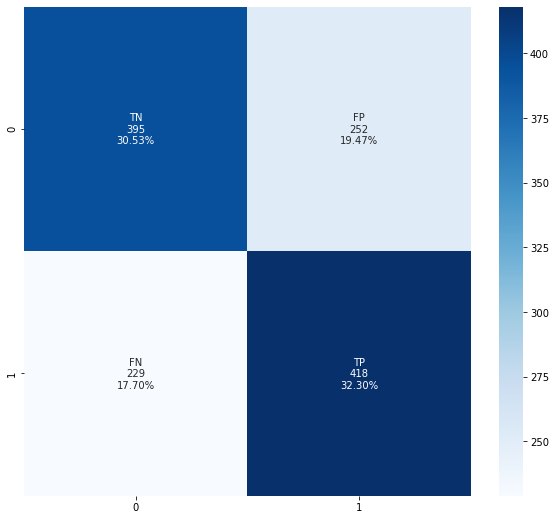

In [29]:
cf_matrix = confusion_matrix(expected_y,predicted_y)
plt.figure(figsize=(10,9))
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, fmt='', cmap='Blues')
plt.show()

### Oversample dataset

In [30]:
x = upsampled.drop(columns=['response','customer_id'])
y = upsampled['response']
identifier = upsampled['customer_id']


for i in range(0,100):
    skf = StratifiedKFold(n_splits=10, random_state = i, shuffle = True)
         
predicted_y = []
expected_y = []
customer_id = []

for train_index, test_index in skf.split(x, y):
    x_train, x_test = x.loc[train_index], x.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    id_train, id_test = identifier[train_index], identifier[test_index]
    
    xgb_model = xgb.XGBClassifier(objective='binary:logistic').fit(x.loc[train_index], y[train_index])
    predictions = xgb_model.predict(x.loc[test_index])

    predicted_y.extend(predictions)
    expected_y.extend(y_test)
    customer_id.extend(id_test)
    
result = {'id': customer_id,'pred': predicted_y, 'exp': expected_y}    
report = classification_report(expected_y, predicted_y)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.84      0.91      4676
           1       0.86      0.99      0.92      4676

    accuracy                           0.91      9352
   macro avg       0.92      0.91      0.91      9352
weighted avg       0.92      0.91      0.91      9352



In [31]:
score = pd.DataFrame(data=result)
score.head()

,id,pred,exp
0,CS3548,0,0
1,CS7714,0,0
2,CS2660,0,0
3,CS1112,0,0
4,CS1830,0,0


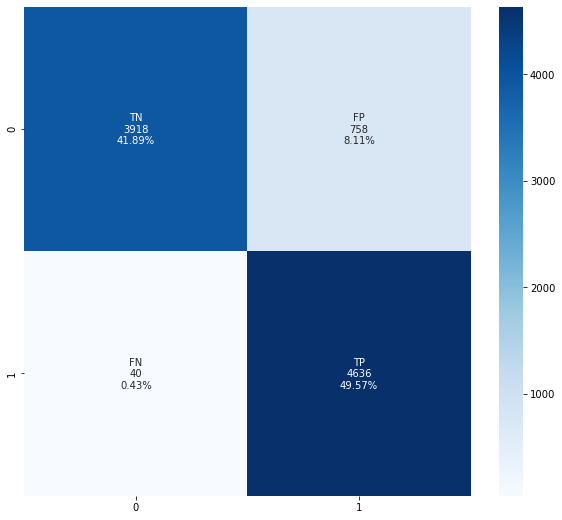

In [32]:
cf_matrix = confusion_matrix(expected_y,predicted_y)
plt.figure(figsize=(10,9))
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, fmt='', cmap='Blues')
plt.show()

In [33]:
x = upsampled.drop(columns=['response','customer_id'])
y = upsampled['response']
identifier = upsampled['customer_id']

for i in range(0,100):
    skf = StratifiedKFold(n_splits=10, random_state = i, shuffle = True)
        
predicted_y = []
expected_y = []
customer_id = []

for train_index, test_index in skf.split(x, y):
    x_train, x_test = x.loc[train_index], x.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    id_train, id_test = identifier[train_index], identifier[test_index]
    
    xgb_model = xgb.XGBClassifier(objective='binary:logistic').fit(x.loc[train_index], y[train_index])
    predictions = xgb_model.predict_proba(x.loc[test_index])[:,1]
    
    predicted_y.extend(predictions)
    expected_y.extend(y_test)
    customer_id.extend(id_test)
    
    
result = {'id': customer_id,'pred': predicted_y, 'exp': expected_y} 
prob_score = pd.DataFrame(data=result)
prob_score.head()

,id,pred,exp
0,CS3548,0.133697,0
1,CS7714,0.000129,0
2,CS2660,0.022364,0
3,CS1112,0.188250,0
4,CS1830,0.195577,0


In [34]:
prob_score.to_csv('xgboost_propensity_score.csv',index=False)

## Logistic Regression Model

In [35]:
x = upsampled.drop(columns=['response','customer_id'])
y = upsampled['response']

logreg = LogisticRegression(solver='liblinear', penalty='l1', C=0.1, class_weight='balanced')

for i in range(0,100):
    skf = StratifiedKFold(n_splits=10, random_state = i, shuffle = True)
        
predicted_y = []
expected_y = []

for train_index, test_index in skf.split(x, y):
    x_train, x_test = x.loc[train_index], x.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    logreg_model = logreg.fit(x.loc[train_index], y[train_index])
    predictions = logreg_model.predict(x.loc[test_index])

    predicted_y.extend(predictions)

    expected_y.extend(y_test)
    
report = classification_report(expected_y, predicted_y)
print(report)

              precision    recall  f1-score   support

           0       0.69      0.64      0.66      4676
           1       0.66      0.72      0.69      4676

    accuracy                           0.68      9352
   macro avg       0.68      0.68      0.68      9352
weighted avg       0.68      0.68      0.68      9352



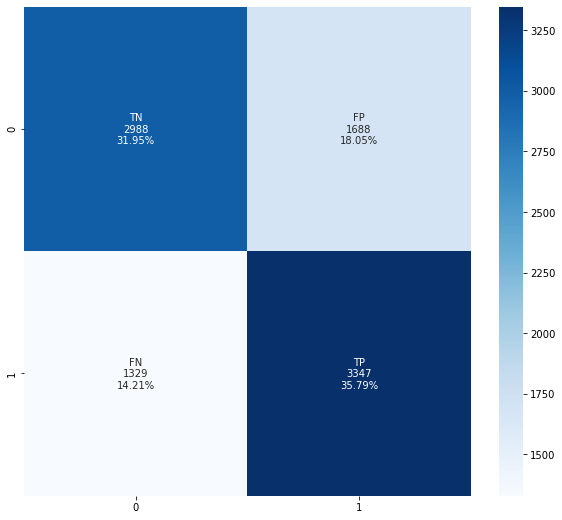

In [36]:
cf_matrix = confusion_matrix(expected_y,predicted_y)
plt.figure(figsize=(10,9))
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, fmt='', cmap='Blues')
plt.show()

In [37]:
x = under_sample.drop(columns=['response','customer_id'])
y = under_sample['response']

logreg = LogisticRegression(solver='liblinear', penalty='l1', C=0.1, class_weight='balanced')

for i in range(0,100):
    skf = StratifiedKFold(n_splits=10, random_state = i, shuffle = True)
        
predicted_y = []
expected_y = []

for train_index, test_index in skf.split(x, y):
    x_train, x_test = x.loc[train_index], x.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    logreg_model = logreg.fit(x.loc[train_index], y[train_index])
    predictions = logreg_model.predict(x.loc[test_index])

    predicted_y.extend(predictions)

    expected_y.extend(y_test)
    
report = classification_report(expected_y, predicted_y)
print(report)

              precision    recall  f1-score   support

           0       0.66      0.56      0.61       647
           1       0.62      0.72      0.66       647

    accuracy                           0.64      1294
   macro avg       0.64      0.64      0.64      1294
weighted avg       0.64      0.64      0.64      1294



/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


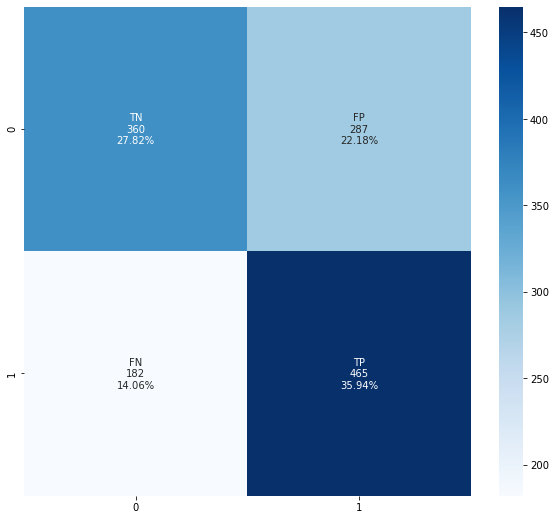

In [38]:
cf_matrix = confusion_matrix(expected_y,predicted_y)
plt.figure(figsize=(10,9))
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, fmt='', cmap='Blues')
plt.show()